In [148]:
from project_paths import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, KFold, ParameterGrid
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

import xgboost

First, we use the test scores of the models evaluated on all the different sets to plot a figure that shows us their performance and then use that to decide the best model to handle this dataset. 

In [4]:
MODEL_EVALUATIONS = load_list_from_pkl(MODEL_EVALUATIONS_PICKLE)

In [19]:
error_bar_data = {}
models = []
for m in MODEL_EVALUATIONS.keys():
    models.append(m)
    error_bar_data[m] = {}
    error_bar_data[m]['data'] = np.array(MODEL_EVALUATIONS[m]['test_scores'])
    error_bar_data[m]['mean'] = np.mean(np.array(MODEL_EVALUATIONS[m]['test_scores']))
    error_bar_data[m]['std'] = np.std(np.array(MODEL_EVALUATIONS[m]['test_scores']))
error_bar_data

x_pos = np.arange(len(models))
fbeta_15s = [error_bar_data[m]['mean'] for m in models]
error = [error_bar_data[m]['std'] for m in models]
model_names = {
    'logistic_regression': 'Logistic',
    'lasso': 'Lasso Regression',
    'xgboost': 'XGBoost',
    'random_forest': 'Random Forest',
    'ridge': 'Ridge Regression',
    'KNN': 'KNN',
}

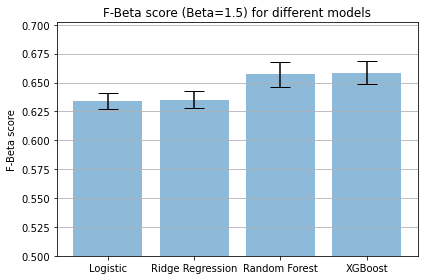

In [25]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, fbeta_15s, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F-Beta score')
ax.set_xticks(x_pos)
ax.set_xticklabels([model_names[x] for x in models])
ax.set_title('F-Beta score (Beta=1.5) for different models')
ax.set_ylim(bottom=0.5)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig(figures_dir + 'bar_plot_with_error_bars.png')
plt.show()

The XGBoost model had the highest test set performance and was chosen as the model of choice. The best set of parameters were selected as the parameters that performed the best on a holdout set.

In [49]:
# Preprocessor
onehot_ftrs = load_list_from_pkl('onehot_ftrs.pkl')
minmax_ftrs = load_list_from_pkl('minmax_ftrs.pkl')
standard_ftrs = load_list_from_pkl('standard_ftrs.pkl')

preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs), 
                 ('minmax', MinMaxScaler(), minmax_ftrs),
                 ('standard', StandardScaler(), standard_ftrs),])

In [84]:
# def find_best_model_on_test_old(X_holdout, y_holdout, best_models):
#     """
#     Accepts best candidate configurations for a given ML model, 
#     runs them across random states on holdout data 
#     and returns results of best one 
#     (Best is found as model which has highest mean fbeta score across random states. 
#     For this model, we return the mean and stdev of fbeta scores across random states.)
#     """
#     BETA = 1.5
#     random_states = [x*5 for x in list(range(5))]
#     models_scores = np.zeros((len(random_states), len(best_models)))
#     # Populate scores for each random state for each model
#     for rs_ix, RANDOM_STATE in enumerate(random_states):
#         X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, 
#                                             train_size = 0.8, random_state=RANDOM_STATE)
#         for m_ix, m in enumerate(best_models):
#             X_train_prep = preprocessor.fit_transform(X_train)
#             X_test_prep = preprocessor.transform(X_test)
#             feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
#                         preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
#             df_train = pd.DataFrame(data=X_train, columns = feature_names)
#             df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

#             eval_set = [(df_test, y_test)]
#             m.fit(df_train, y_train,
#                     early_stopping_rounds=50, eval_set=eval_set, verbose=False)
#             y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
            
#             models_scores[rs_ix, m_ix] = fbeta_score(y_test, y_test_pred, beta=BETA)
    
#     model_wise_scores = models_scores.mean(axis=0)
#     best_model = best_models[np.argmax(model_wise_scores)]
#     best_score = np.max(model_wise_scores)
#     random_state_wise_stdev = np.mean(models_scores.std(axis=1))
#     return best_model, best_score, random_state_wise_stdev, model_wise_scores

# best_model, best_score, random_state_wise_stdev, model_wise_scores = find_best_model_on_test_old(X_other, y_other,
#                                                                             X_holdout, y_holdout, 
#                                                                           MODEL_EVALUATIONS['xgboost']['best_models'])

In [100]:
X_other = load_list_from_pkl('X_other.pkl')
y_other = load_list_from_pkl('y_other.pkl')
X_holdout = load_list_from_pkl('X_holdout.pkl')
y_holdout = load_list_from_pkl('y_holdout.pkl')

In [195]:
# Finding the best XGB boost model by checking on Test
best_models = MODEL_EVALUATIONS['xgboost']['best_models']

BETA = 1.5
# Populate scores for each random state for each model
random_states = [x*5 for x in list(range(5))]
models_scores = np.zeros((len(random_states), len(best_models)))
# Populate scores for each random state for each model
X_train_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_holdout)
y_train = y_other
y_test = y_holdout
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)
for rs_ix, RANDOM_STATE in enumerate(random_states):
    for m_ix, m in enumerate(best_models):
        eval_set = [(df_test, y_test)]
        m.random_state=RANDOM_STATE
        m.fit(df_train, y_train, 
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)
        y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
        models_scores[rs_ix, m_ix] = fbeta_score(y_test, y_test_pred, beta=BETA)

model_wise_scores = models_scores.mean(axis=0)
best_model = best_models[np.argmax(model_wise_scores)]
best_score = np.max(model_wise_scores)
random_state_wise_stdev = np.mean(models_scores.std(axis=1))

[08:09:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:09:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:09:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:10:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [99]:
model_wise_scores, best_model, best_score, random_state_wise_stdev

(array([0.65680427, 0.65660198, 0.65639445, 0.65672174, 0.65496105,
        0.66185371, 0.6590595 , 0.65444343, 0.65959552, 0.65455409]),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9,
               eval_metric=make_scorer(fbeta_score, beta=1.5), gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=7, num_parallel_tree=1, random_state=25,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=25,
               subsample=0.66, tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.6618537125677438,
 0.002274983649742198)

After choosing the best model and hyperparameter choice, the model was retrained on new splits over 10 new random states. For each split, 80% of the data was allocated to training and 20% was allocated to testing. For each random state, the preprocessed test set, model, and baseline accuracy score were recorded.

### Calculating baseline scores

In [139]:
from sklearn.dummy import DummyClassifier
random_states = [x*5 for x in list(range(10))]
baseline_scores = []
for RANDOM_STATE in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, 
                                        train_size = 0.6, random_state=RANDOM_STATE)
    dummy_clf.fit(X_train, y_train)
    y_test_preds = dummy_clf.predict(X_test)
    baseline_scores.append(fbeta_score(y_test, y_test_preds, beta=BETA))

baseline_scores = np.array(baseline_scores)
baseline_scores.mean(), baseline_scores.std()

(0.07470127102519217, 0.2241038130755765)

### ROC Curve & Confusion Matrix

In [214]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Finding the best XGB boost model by checking on Test
best_models = MODEL_EVALUATIONS['xgboost']['best_models']
random_states = [x*5 for x in list(range(5))]

confusion_matrices = []
tprs = []
fprs = []
for RANDOM_STATE in random_states:
    X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_other, y_other, 
                                                train_size = 0.8, random_state=RANDOM_STATE)

    # Populate scores for each random state for each model
    X_train_prep = preprocessor.fit_transform(X_train_eval)
    X_test_prep = preprocessor.transform(X_test_eval)
    y_train = y_train_eval
    y_test = y_test_eval
    feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
                preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
    df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
    df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

    eval_set = [(df_test, y_test)]
    best_model.fit(df_train, y_train,
            early_stopping_rounds=50, eval_set=eval_set, verbose=False)
    y_test_pred = best_model.predict(df_test, ntree_limit=m.best_ntree_limit)
    
    C = confusion_matrix(y_test, y_test_pred)
    C_normal = confusion_matrix(y_test, y_test_pred, normalize='true')
    confusion_matrices.append(C_normal)

    y_test_pred_prob = best_model.predict_proba(df_test, ntree_limit=m.best_ntree_limit)
    pred_prob_class1 = y_test_pred_prob[:, 1]
    fpr = np.zeros(len(y_test_pred_prob))
    tpr = np.zeros(len(y_test_pred_prob))

    p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

    for i in range(len(p_crits)):
        p_crit = p_crits[i]

        y_pred = np.zeros(len(y_test_pred_prob))
        y_pred[pred_prob_class1 < p_crit] = 0
        y_pred[pred_prob_class1 >= p_crit] = 1

        tpr[i] = C[1,1]/(C[1,0]+C[1,1])
        fpr[i] = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)

[12:01:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [216]:
averaged_confusion_mat = np.zeros((2, 2))
averaged_confusion_mat[0,0] = np.mean([a[0,0] for a in confusion_matrices])
averaged_confusion_mat[0,1] = np.mean([a[0,1] for a in confusion_matrices])
averaged_confusion_mat[1,0] = np.mean([a[1,0] for a in confusion_matrices])
averaged_confusion_mat[1,1] = np.mean([a[1,1] for a in confusion_matrices])
averaged_confusion_mat

averaged_confusion_mat

array([[0.69001283, 0.30998717],
       [0.34264893, 0.65735107]])

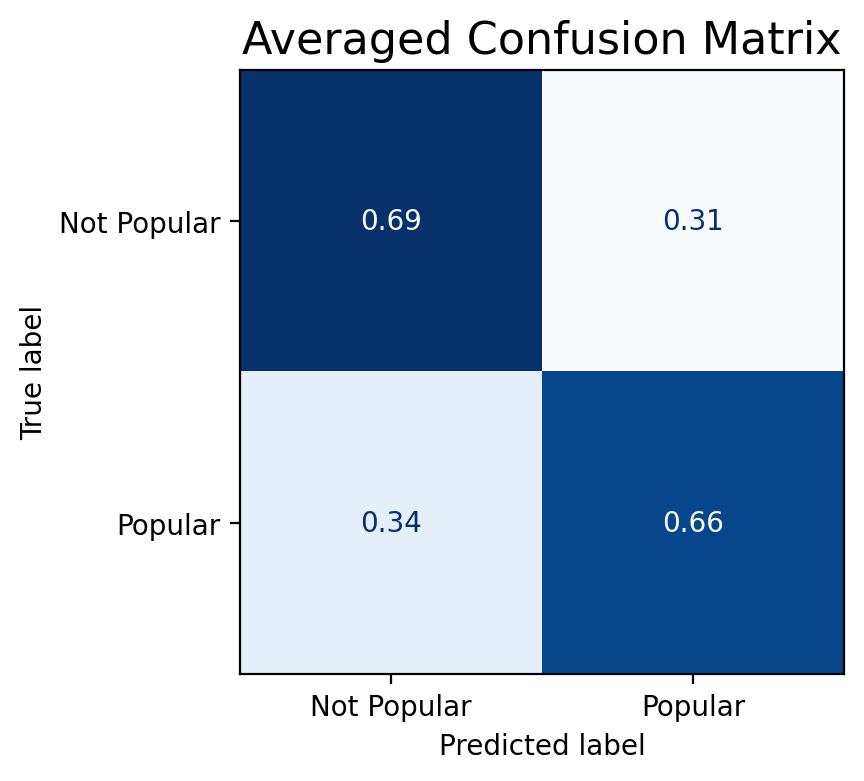

<Figure size 800x600 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [251]:
# cm = confusion_matrix(y_test, y_test_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=averaged_confusion_mat,
                               display_labels=["Not Popular", "Popular"])
disp.plot(colorbar=False, cmap="Blues")
plt.title("Averaged Confusion Matrix", fontsize=16)
plt.figure(figsize=(4, 3))
plt.rcParams["figure.dpi"] = 300
plt.show()
plt.savefig(figures_dir + 'confusion_mat.png')

In [ ]:
X_train_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_holdout)
y_train = y_other
y_test = y_holdout

feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

eval_set = [(df_test, y_test)]
best_model.fit(df_train, y_train,
        early_stopping_rounds=50, eval_set=eval_set, verbose=False)
y_test_pred = best_model.predict(df_test, ntree_limit=m.best_ntree_limit)

C = confusion_matrix(y_test, y_test_pred)
C_normal = confusion_matrix(y_test, y_test_pred, normalize='true')
confusion_matrices.append(C_normal)

y_test_pred_prob = best_model.predict_proba(df_test, ntree_limit=m.best_ntree_limit)
pred_prob_class1 = y_test_pred_prob[:, 1]
fpr = np.zeros(len(y_test_pred_prob))
tpr = np.zeros(len(y_test_pred_prob))

p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

for i in range(len(p_crits)):
    p_crit = p_crits[i]

    y_pred = np.zeros(len(y_test_pred_prob))
    y_pred[pred_prob_class1 < p_crit] = 0
    y_pred[pred_prob_class1 >= p_crit] = 1

    tpr[i] = C[1,1]/(C[1,0]+C[1,1])
    fpr[i] = C[0,1]/(C[0,0]+C[0,1])
tprs.append(tpr)
fprs.append(fpr)

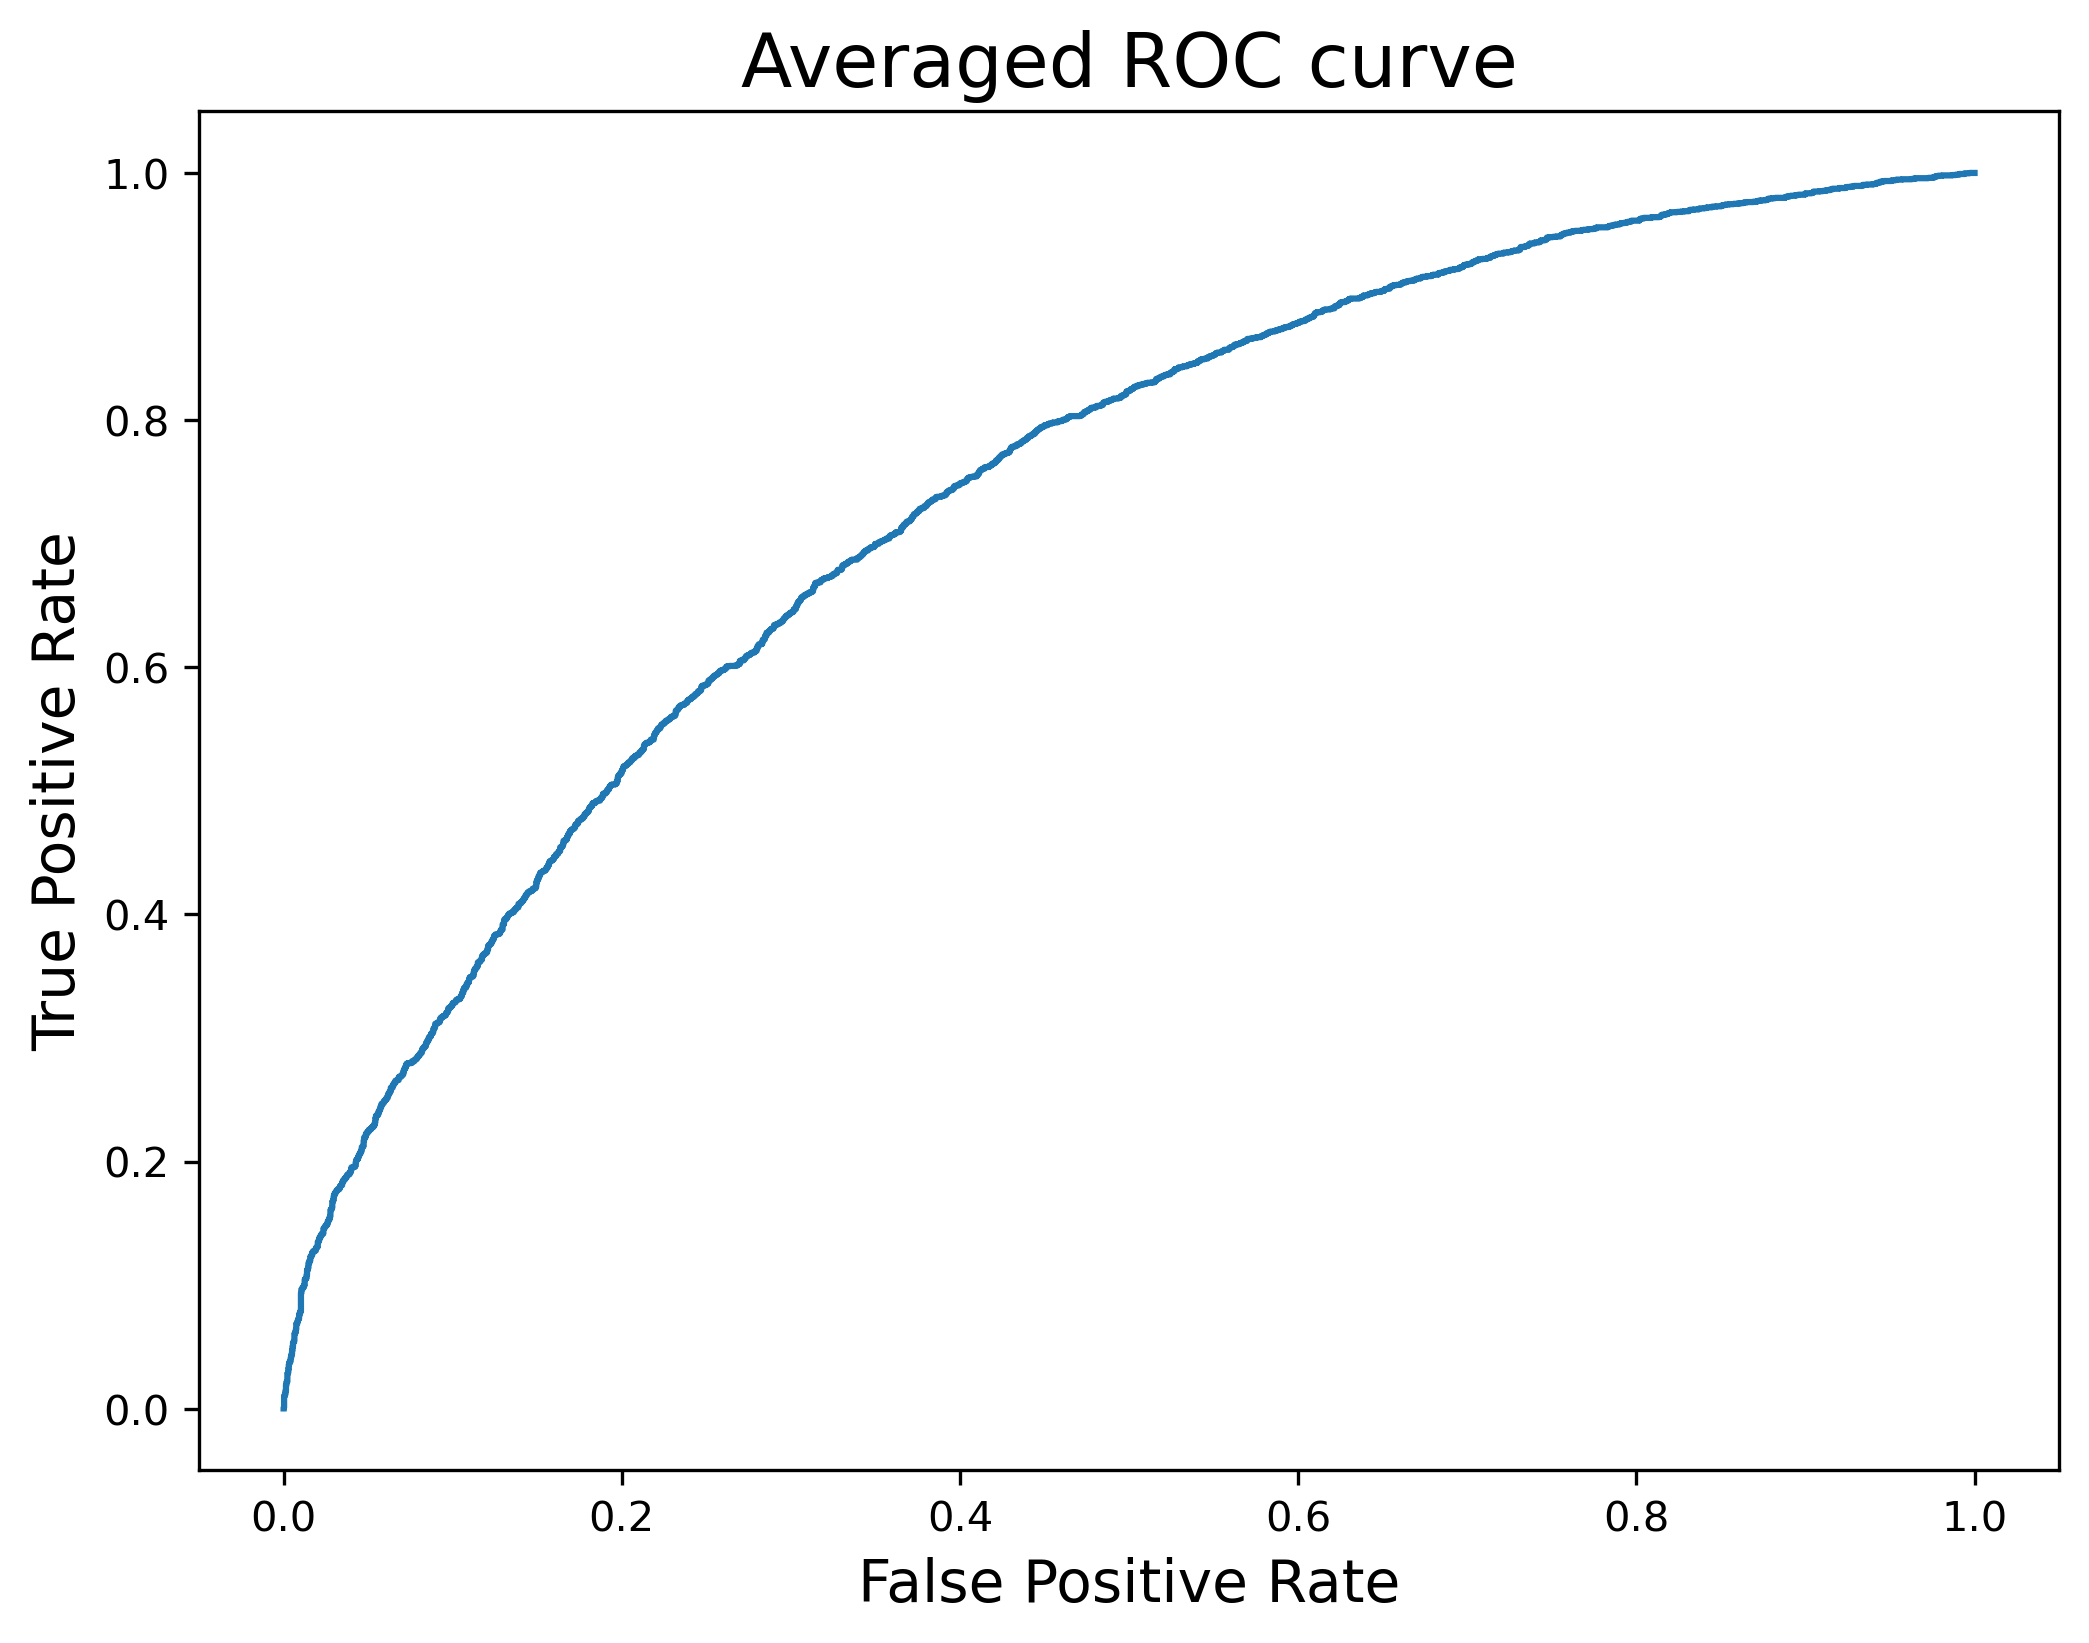

<Figure size 1800x1200 with 0 Axes>

In [252]:
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Averaged ROC curve', fontsize=18)
plt.rcParams["figure.dpi"] = 300
plt.show()
plt.savefig(figures_dir + 'roc_curve.png')

In [140]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_other, y_other,
                                    test_size=0.2, random_state=101)
cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]

In [143]:
metrics = ['auc', 'fpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val' : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics},
}

params = {
    'objective': 'binary:logistic',
    'eval_metric' : 'logloss'
}

In [ ]:
random_states = [x*5 for x in list(range(5))]
X_train_prep = preprocessor.fit_transform(X_other)
y_train = y_other
y_test = y_holdout
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)
for rs_ix, RANDOM_STATE in enumerate(random_states):
    for m_ix, m in enumerate(best_models):
        eval_set = [(df_test, y_test)]
        m.fit(df_train, y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)
        y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
        models_scores[rs_ix, m_ix] = fbeta_score(y_test, y_test_pred, beta=BETA)

model_wise_scores = models_scores.mean(axis=0)
best_model = best_models[np.argmax(model_wise_scores)]
best_score = np.max(model_wise_scores)
random_state_wise_stdev = np.mean(models_scores.std(axis=1))

In [152]:
dtest = xgboost.DMatrix(X_test, label=y_test)
for train, test in tqdm(folds, total=len(folds)):
    X_train.iloc[train,:]
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
                preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
    df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
    df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)
    
    dtrain = xgboost.DMatrix(X_train_prep.iloc[train,:], label = y_train.iloc[train], enable_categorical=True)
    dval = xgboost.DMatrix(X_train_prep.iloc[test,:], label = y_train.iloc[test], enable_categorical=True)
    model = best_model
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds = model.predict(sets[i])
        labels = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.day_of_week, topic